<a href="https://colab.research.google.com/github/shreekar2005/Cheminformatics_DC/blob/main/DC2_NN_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import cudf
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_auc_score

In [2]:
# Load data into cudf (GPU DataFrame)
url1 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TRAIN_dense/tox21_dense_train.csv'
url2 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TRAIN_dense/tox21_labels_train.csv'
url3 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TEST_dense/tox21_dense_test.csv'
url4 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TEST_dense/tox21_labels_test.csv'

train_features = cudf.read_csv(url1)
train_labels = cudf.read_csv(url2)
test_features = cudf.read_csv(url3)
test_labels = cudf.read_csv(url4)

target_labels = ['NR.AhR', 'NR.AR', 'NR.AR.LBD', 'NR.Aromatase', 'NR.ER', 'NR.ER.LBD',
                 'NR.PPAR.gamma', 'SR.ARE', 'SR.ATAD5', 'SR.HSE', 'SR.MMP', 'SR.p53']

dense_features = train_features.select_dtypes(include=['float64', 'int64']).columns.tolist()
X_train = train_features[dense_features].to_cupy()
X_test = test_features[dense_features].to_cupy()

# Standardize features for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.get())
X_test = scaler.transform(X_test.get())

train_labels[target_labels] = train_labels[target_labels].fillna(0).clip(0, 1)
test_labels[target_labels] = test_labels[target_labels].fillna(0).clip(0, 1)

y_train = train_labels[target_labels].to_cupy()
y_test = test_labels[target_labels].to_cupy()

# Convert CuPy arrays to NumPy for PyTorch compatibility
y_train = y_train.get()
y_test = y_test.get()
X_train = X_train
X_test = X_test

# Convert NumPy arrays to PyTorch tensors
def to_tensor(array):
    return torch.tensor(array, dtype=torch.float32)

X_train_torch = to_tensor(X_train)
X_test_torch = to_tensor(X_test)
y_train_torch = to_tensor(y_train)
y_test_torch = to_tensor(y_test)

In [3]:
print(X_train_torch.shape)
print(y_train_torch.shape)
print(X_test_torch.shape)
print(y_test_torch.shape)
# print(y_test_torch[3])

# Number of new samples
num_new_samples = 5000

# Get the number of existing samples
num_samples = X_train_torch.shape[0]

# Randomly select indices for triplets
idx1 = torch.randint(0, num_samples, (num_new_samples,))
idx2 = torch.randint(0, num_samples, (num_new_samples,))
idx3 = torch.randint(0, num_samples, (num_new_samples,))

# Compute new X by averaging features
X_new = (X_train_torch[idx1] + X_train_torch[idx2] + X_train_torch[idx3]) / 3.0

# Convert y to boolean before OR operation
y_new = (y_train_torch[idx1].bool() | y_train_torch[idx2].bool() | y_train_torch[idx3].bool()).float()

# Concatenate with the original dataset
X_train_torch_new = torch.cat([X_train_torch, X_new], dim=0)
y_train_torch_new = torch.cat([y_train_torch, y_new], dim=0)

# Print new shapes
print(X_train_torch_new.shape)
print(y_train_torch_new.shape)

# Create PyTorch DataLoader
def create_dataloader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train_torch, y_train_torch)
test_loader = create_dataloader(X_test_torch, y_test_torch, batch_size=32, shuffle=False)


torch.Size([12060, 801])
torch.Size([12060, 12])
torch.Size([647, 801])
torch.Size([647, 12])
torch.Size([17060, 801])
torch.Size([17060, 12])


In [4]:
# Define Flexible Neural Network Class
class FlexibleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[512, 256], dropout_rate=0.2):
        super(FlexibleNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())  # Multi-label classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [5]:
# Model initialization with flexibility
input_size = X_train.shape[1]
output_size = y_train.shape[1]

hidden_layers = [1024, 512, 256, 512, 256]  # Increased neurons to improve TPR
dropout_rate = 0.1  # Reduced dropout rate to retain more features

model = FlexibleNN(input_size, output_size, hidden_layers, dropout_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FlexibleNN(
  (model): Sequential(
    (0): Linear(in_features=801, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=512, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, 

In [6]:

# Custom Weighted BCE Loss to Reduce False Negatives
class CustomBCELoss(nn.Module):
    def __init__(self, pos_weight=2.0):  # Increase weight for positives
        super(CustomBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

    def forward(self, outputs, targets):
        loss = self.bce(outputs, targets)
        return loss

# Define loss with higher positive weight
criterion = CustomBCELoss(pos_weight=10.0)  # Increase this if FN still exists
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    epoch_losses = []  # Store loss values for plotting
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot loss vs epochs
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs. Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/20, Loss: 0.9954
Epoch 2/20, Loss: 0.9675
Epoch 3/20, Loss: 0.9627
Epoch 4/20, Loss: 0.9607
Epoch 5/20, Loss: 0.9575
Epoch 6/20, Loss: 0.9551
Epoch 7/20, Loss: 0.9535
Epoch 8/20, Loss: 0.9510
Epoch 9/20, Loss: 0.9494
Epoch 10/20, Loss: 0.9470
Epoch 11/20, Loss: 0.9468
Epoch 12/20, Loss: 0.9467
Epoch 13/20, Loss: 0.9443
Epoch 14/20, Loss: 0.9442
Epoch 15/20, Loss: 0.9404
Epoch 16/20, Loss: 0.9405
Epoch 17/20, Loss: 0.9402
Epoch 18/20, Loss: 0.9410
Epoch 19/20, Loss: 0.9375
Epoch 20/20, Loss: 0.9377


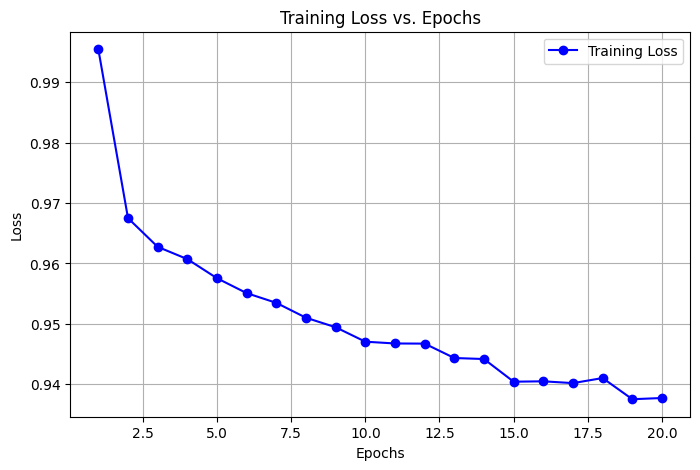

In [7]:
# Training
train_model(model, train_loader, criterion, optimizer, epochs=20)

[7.0779035e-03 6.1411711e-08 6.8091019e-08 4.7388139e-06 3.6955631e-04
 3.2046998e-07 6.1498140e-06 2.2054196e-06 2.2448314e-06 5.1941004e-08
 2.2425570e-06 7.2537483e-07]


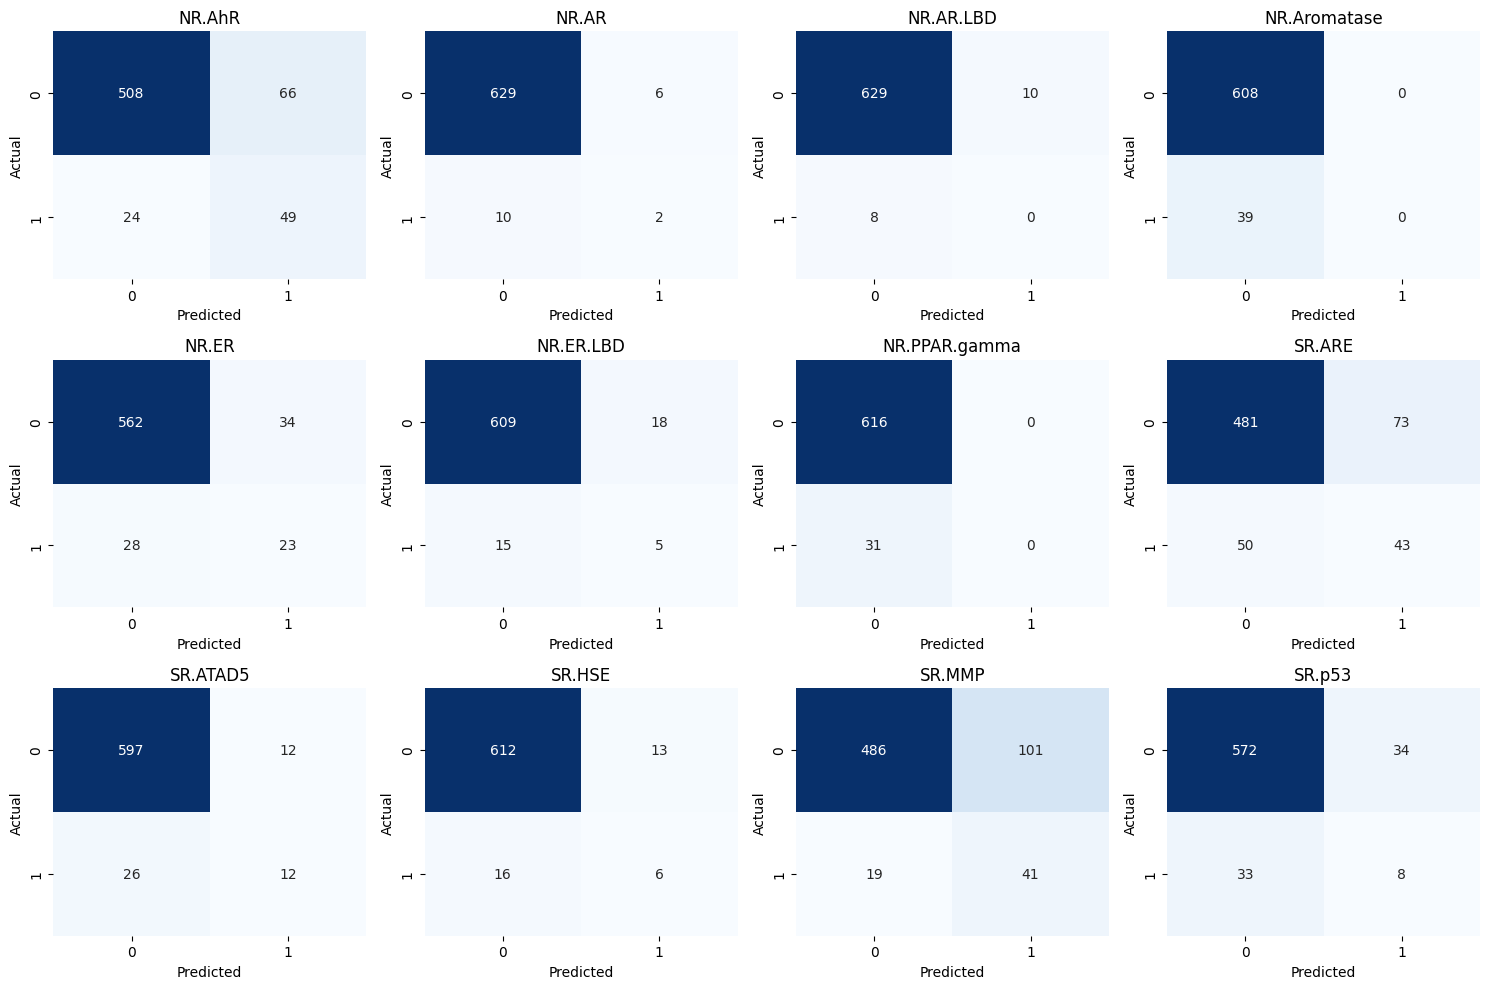

               precision    recall  f1-score   support

       NR.AhR       0.43      0.67      0.52        73
        NR.AR       0.25      0.17      0.20        12
    NR.AR.LBD       0.00      0.00      0.00         8
 NR.Aromatase       0.00      0.00      0.00        39
        NR.ER       0.40      0.45      0.43        51
    NR.ER.LBD       0.22      0.25      0.23        20
NR.PPAR.gamma       0.00      0.00      0.00        31
       SR.ARE       0.37      0.46      0.41        93
     SR.ATAD5       0.50      0.32      0.39        38
       SR.HSE       0.32      0.27      0.29        22
       SR.MMP       0.29      0.68      0.41        60
       SR.p53       0.19      0.20      0.19        41

    micro avg       0.34      0.39      0.36       488
    macro avg       0.25      0.29      0.26       488
 weighted avg       0.30      0.39      0.32       488
  samples avg       0.09      0.11      0.09       488



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [11]:
# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            all_preds.append(outputs)
            all_labels.append(y_batch.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

# Get predictions
preds, labels = evaluate_model(model, test_loader)

# **Important: Adjust threshold to prioritize True Positives**
threshold = 0.5  # Reduce threshold to capture more positives
print(preds[0])
preds = (preds > threshold).astype(int)


# Compute multi-label confusion matrices
conf_matrices = multilabel_confusion_matrix(labels, preds)

# Plot confusion matrices for each label
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 labels
axes = axes.flatten()

for i, (ax, label) in enumerate(zip(axes, target_labels)):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Print detailed metrics
print(classification_report(labels, preds, target_names=target_labels))

In [14]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            all_preds.append(outputs)
            all_labels.append(y_batch.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

# Get predictions from the model
preds, labels = evaluate_model(model, test_loader, device)

# **Important: Adjust threshold to prioritize True Positives**
threshold = 0.5  # Reduce threshold to capture more positives
preds = (preds > threshold).astype(int)  # Apply threshold to predictions

# Print detailed metrics per assay
print("\nEvaluation Metrics per Assay:")
print("-"*60)

for i, label in enumerate(target_labels):
    print(f"\nAssay {i+1}: {label}")

    # Get true labels and predictions for the current label
    true_labels = labels[:, i]
    preds_label = preds[:, i]

    # If there are no positive labels, skip classification report
    if np.sum(true_labels) == 0:
        print(f"⚠️ No positive labels for assay {label} — skipping classification report.")
        continue

    # If there are no positive predictions, skip classification report
    if np.sum(preds_label) == 0:
        print(f"⚠️ No positive predictions for assay {label} — skipping classification report.")
        continue

    # Classification report
    report = classification_report(true_labels, preds_label, output_dict=True)
    print(f"macro avg  precision: {report['macro avg']['precision']:.6f} | "
          f"recall: {report['macro avg']['recall']:.6f} | "
          f"f1-score: {report['macro avg']['f1-score']:.6f} | "
          f"support: {report['macro avg']['support']}")
    print(f"weighted avg precision: {report['weighted avg']['precision']:.6f} | "
          f"recall: {report['weighted avg']['recall']:.6f} | "
          f"f1-score: {report['weighted avg']['f1-score']:.6f} | "
          f"support: {report['weighted avg']['support']}")

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_labels, preds_label).ravel()
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # Compute AUC for multi-label classification
    auc = roc_auc_score(true_labels, preds_label)
    print(f"AUC for {label}: {auc:.5f}")

    # Additional diagnostics for the assay if no positives are predicted
    if np.sum(preds_label) == 0:
        print(f"Warning: No positive predictions for assay {label}.")
        print(f"Positive samples in the test set: {np.sum(true_labels)}")
        print(f"Predicted positives: {np.sum(preds_label)}")
        print("Consider adjusting the threshold, checking class imbalance, or modifying model parameters.")


Evaluation Metrics per Assay:
------------------------------------------------------------

Assay 1: NR.AhR
macro avg  precision: 0.690487 | recall: 0.778125 | f1-score: 0.719951 | support: 647.0
weighted avg precision: 0.895224 | recall: 0.860896 | f1-score: 0.873793 | support: 647.0
Confusion Matrix: TN=508, FP=66, FN=24, TP=49
AUC for NR.AhR: 0.77813

Assay 2: NR.AR
macro avg  precision: 0.617175 | recall: 0.578609 | f1-score: 0.593721 | support: 647.0
weighted avg precision: 0.970730 | recall: 0.975270 | f1-score: 0.972836 | support: 647.0
Confusion Matrix: TN=629, FP=6, FN=10, TP=2
AUC for NR.AR: 0.57861

Assay 3: NR.AR.LBD
macro avg  precision: 0.493721 | recall: 0.492175 | f1-score: 0.492947 | support: 647.0
weighted avg precision: 0.975232 | recall: 0.972179 | f1-score: 0.973703 | support: 647.0
Confusion Matrix: TN=629, FP=10, FN=8, TP=0
AUC for NR.AR.LBD: 0.49218

Assay 4: NR.Aromatase
⚠️ No positive predictions for assay NR.Aromatase — skipping classification report.

Assay